In [8]:
import networkx as nx 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
import pandas as pd
import gc
import torch_geometric as pyg 

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.datasets import simulate_3_in_3_out

from gsnn.optim.TrainingDiagnostics import TrainingDiagnostics
from gsnn.optim.GradDiagnostics import GradDiagnostics


# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


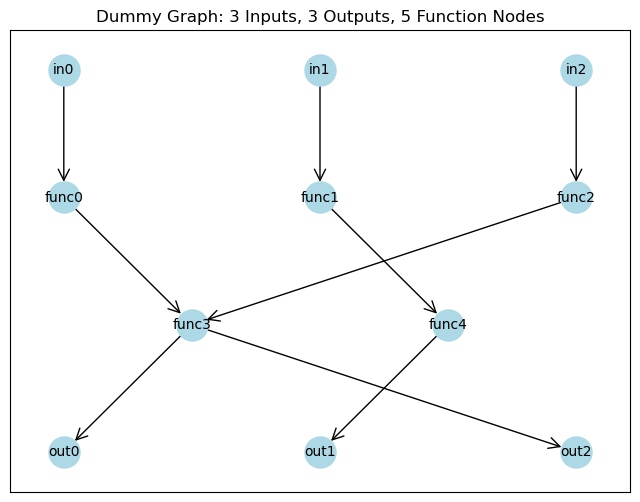

In [9]:
G, pos, x_train, x_test, y_train, y_test, input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=10, n_test=100, noise_scale=0.1, device='cuda')

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=10, 
             layers=10,
             dropout=0.,
             share_layers=False, 
             bias=False,
             add_function_self_edges=False,
             checkpoint=False, 
             node_attn=True,
             norm='groupbatch', 
             residual=True).to(device)

diagnostics = GradDiagnostics(window_size=100)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
crit = torch.nn.MSELoss()

for i in range(100):
    model.train() 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    diagnostics.update(model, loss.item(), i, threshold=1e-5)
    
    model.eval() 
    with torch.no_grad():
        yhat = model(x_test)
        loss = crit(y_test, yhat)

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

model = model.eval()

n params 14230
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.6.node_attn.beta']
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.0.node_attn.beta']
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.3.node_attn.beta']
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.3.node_attn.beta']
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.9.node_attn.beta']
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.5.node_attn.beta']
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.7.node_attn.beta']
[GradDiagnostics] Warning: Layers with >99% vanishing gradients: ['ResBlocks.9.node_attn.mlp.2.bias']


In [37]:
summary = diagnostics.get_summary()

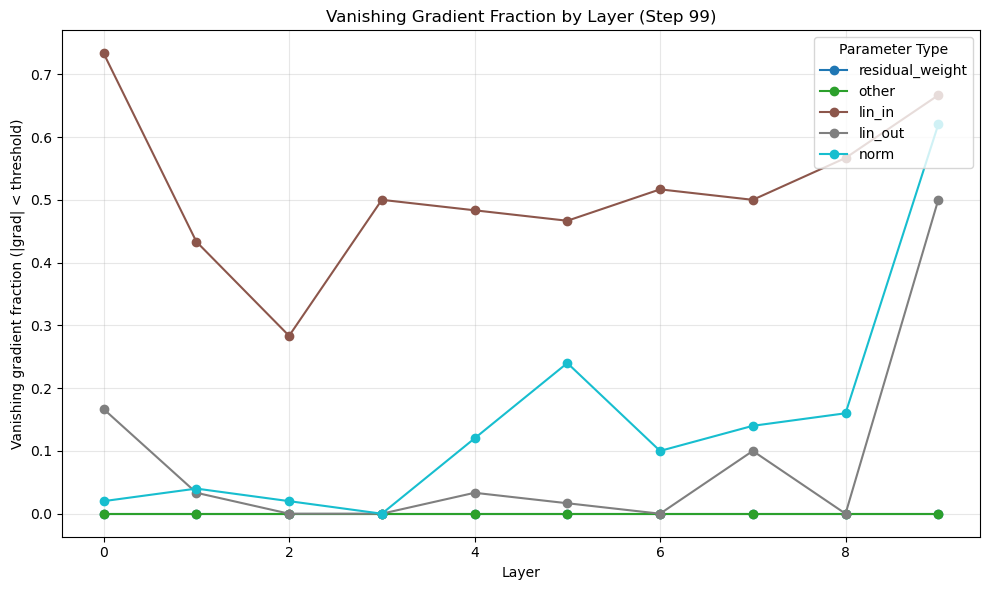

In [38]:
_ = diagnostics.plot_diagnostics(step = 99)

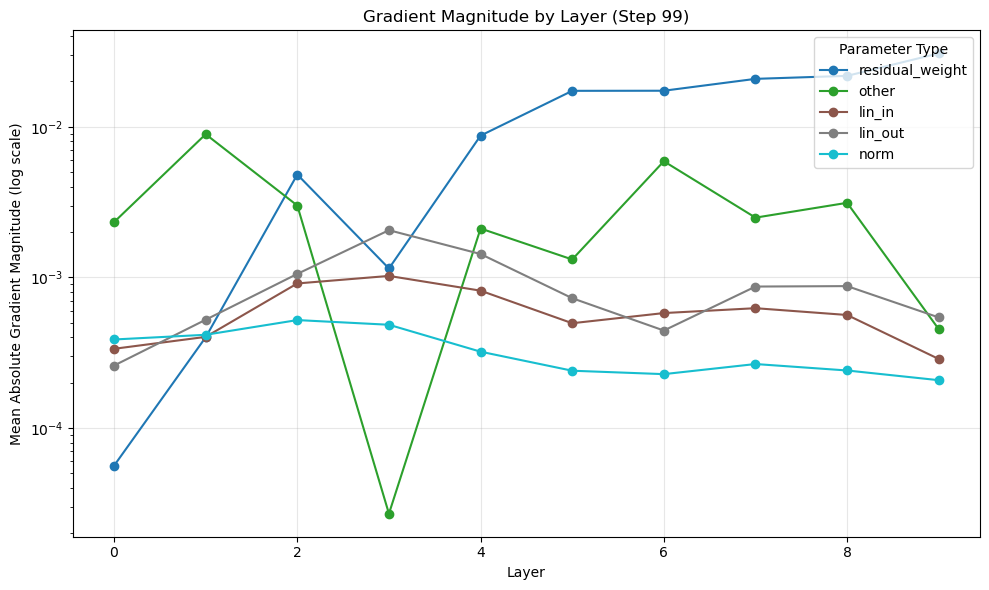

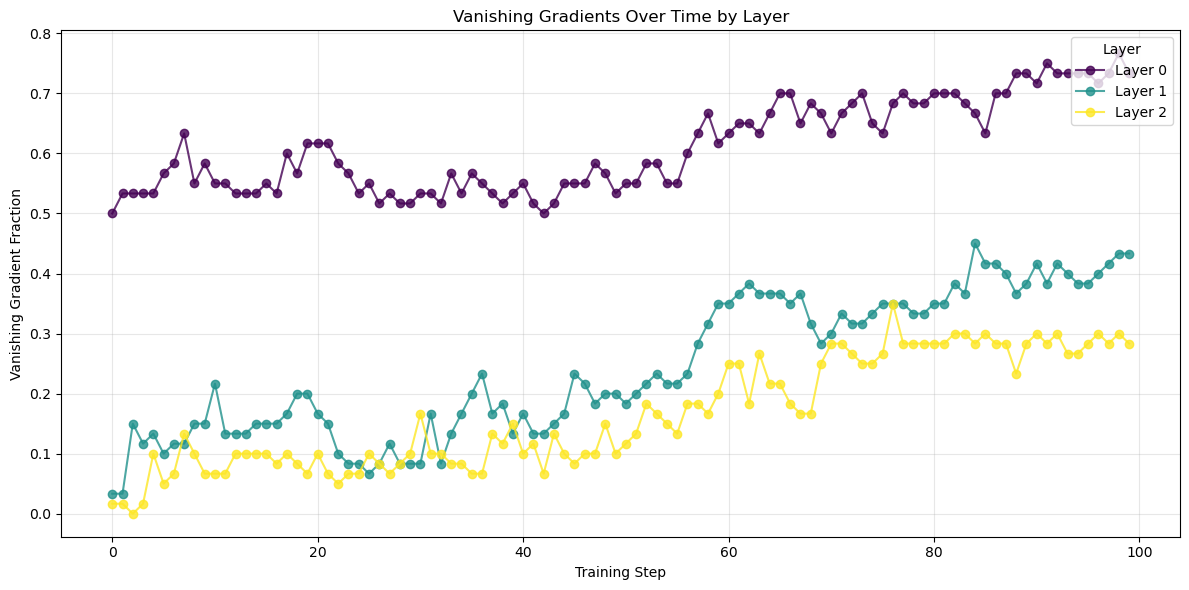

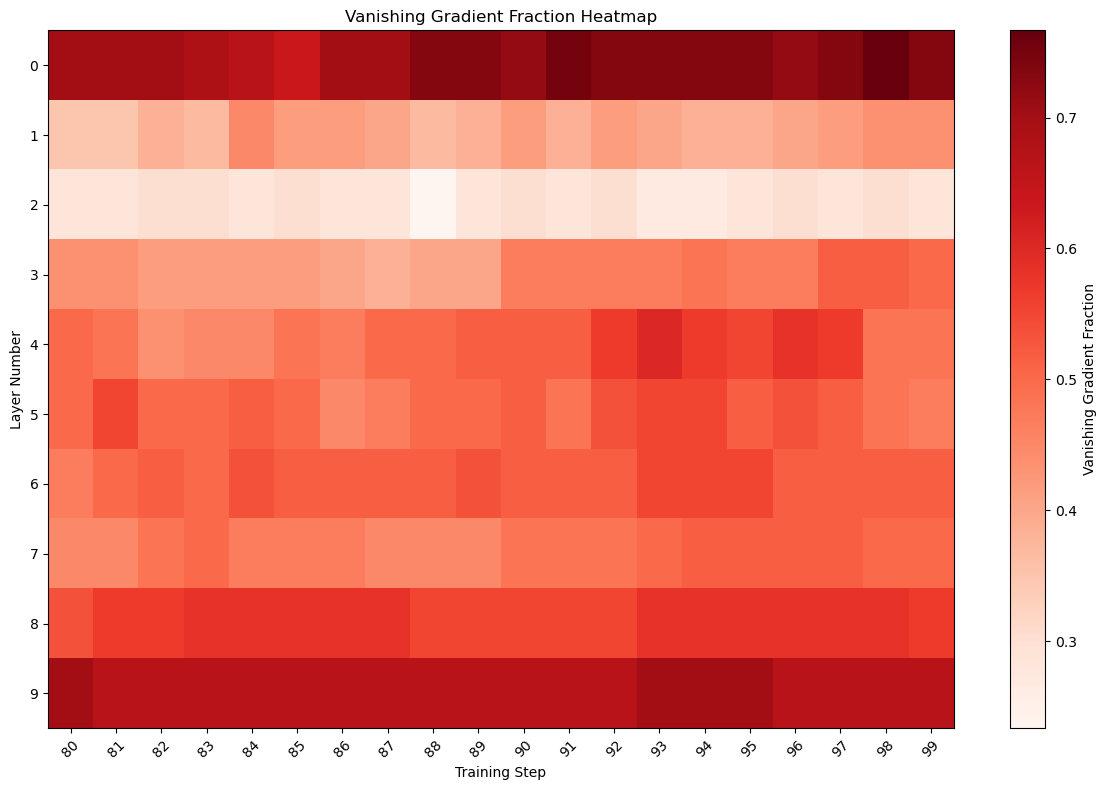

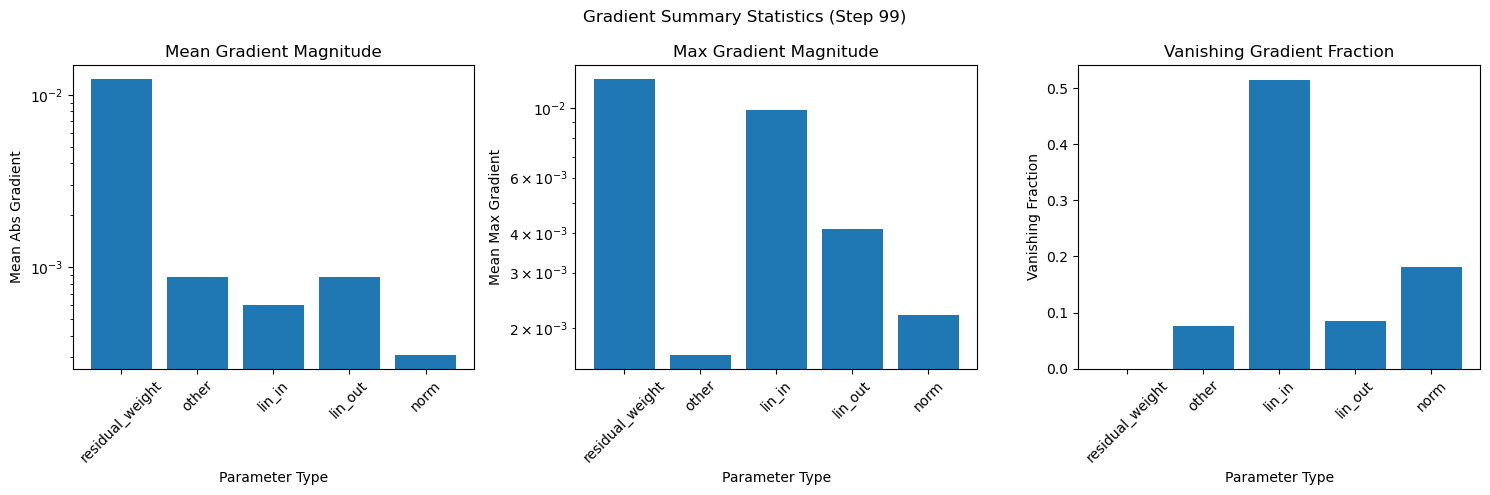

In [39]:
diagnostics.plot_gradient_magnitude_by_layer()
diagnostics.plot_vanishing_over_time([0, 1, 2])
diagnostics.plot_gradient_ratio_heatmap(20)
diagnostics.plot_summary_statistics()